This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import fitter, plot_utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

[ 000000.00 ]: 09-23 01:49  root            INFO     No pypower module detected, gridding with this method is unavailable
ERROR:2025-09-23 01:49:25,926:jax._src.xla_bridge:502: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda13.initialize()
Traceback (most recent call last):
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 500, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax_plugins/xla_cuda13/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax_plugins/xla_cuda13/__init__.py", line 150, in _check_cuda_versions
    assert cuda_versions is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
[ 000000.20 ]: 09-23 01:49  jax._src.xla_bridge ERROR    

In [3]:
grid = pd.read_parquet(data_path / "density_data.parquet")
grid_window = pd.read_parquet(data_path / "grid_window_m.parquet")

DataDensity = data_vector.Dens(grid.rename(columns={'density_err': 'density_error', 'rcom': 'rcom_zobs'}).to_dict(orient='list'))

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmag_fiducial = 6.0

power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],
                              [kmt, pmt * np.array(grid_window["window_mt"])],
                              [ktt, ptt]]}


# Fit fs8 

In [4]:
size_batch=500_000
number_worker=8
covariance_fit = DataDensity.compute_covariance(
    "ravouxcarreres", power_spectrum_dict, size_batch=size_batch, 
    number_worker=number_worker, additional_parameters_values=(sigmag_fiducial,), variant="nobeta",
)

 /global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[ 000009.07 ]: 09-23 01:49  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 8.99e+00 seconds


In [5]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky_inverse"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }




minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)
print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['fs8', 'bs8']


[ 000014.46 ]: 09-23 01:49  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1535                       │              Nfcn = 43               │
│ EDM = 3.07e-05 (Goal: 0.0001)    │            time = 4.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'bs8': 0.8450690076831278, 'fs8': 0.5328292634189377}

# Fit fs8 with an interpolation scheme for sigma_g

In [6]:
sigmag_list = np.linspace(0.5, 3.0, 10)
covariance_list = []


for sigg in sigmag_list:
    covariance_list.append(
        DataDensity.compute_covariance(
            "ravouxcarreres", 
            power_spectrum_dict, 
            size_batch=size_batch, 
            number_worker=number_worker, 
            additional_parameters_values=(sigg,), 
            variant="nobeta"
        )
    )


[ 000021.84 ]: 09-23 01:49  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 7.37e+00 seconds
[ 000029.83 ]: 09-23 01:49  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 7.80e+00 seconds
[ 000038.17 ]: 09-23 01:50  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 8.14e+00 seconds
[ 000045.87 ]: 09-23 01:50  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 7.50e+00 seconds
[ 000053.81 ]: 09-23 01:50  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 7.76e+00 seconds
[ 000062.22 ]: 09-23 01:50  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 8.17e+00 seconds
[ 000071.30 ]: 09-23 01:50  root            INFO     Covariance matrix generated from flip with ravouxcarreres model in 8.89e+00 seconds
[ 000080.23 ]: 09-23 01:50  root         

In [7]:
parameter_dict = {"bs8": {"value": 1.0,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "fs8": {"value": 0.4,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "sigg": {"value": 2.0,
                          "limit_low" : 0.5,
                          "limit_up" : 3.0,
                          "fixed" : False,
                         },
                 }    



likelihood_type = "multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "inverse"}



minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigg",
        interpolation_value_range = sigmag_list,
)

print('Free parameters are:', minuit_fitter_interp.likelihood.free_par)

minuit_fitter_interp.run()


Free parameters are: ['sigg', 'fs8', 'bs8']


[ 000260.63 ]: 09-23 01:53  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1527                       │              Nfcn = 168              │
│ EDM = 3.93e-07 (Goal: 0.0001)    │           time = 163.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'bs8': 0.8592786096164942,
 'fs8': 0.10329988032839166,
 'sigg': 0.5000034514261524}

# Some plots

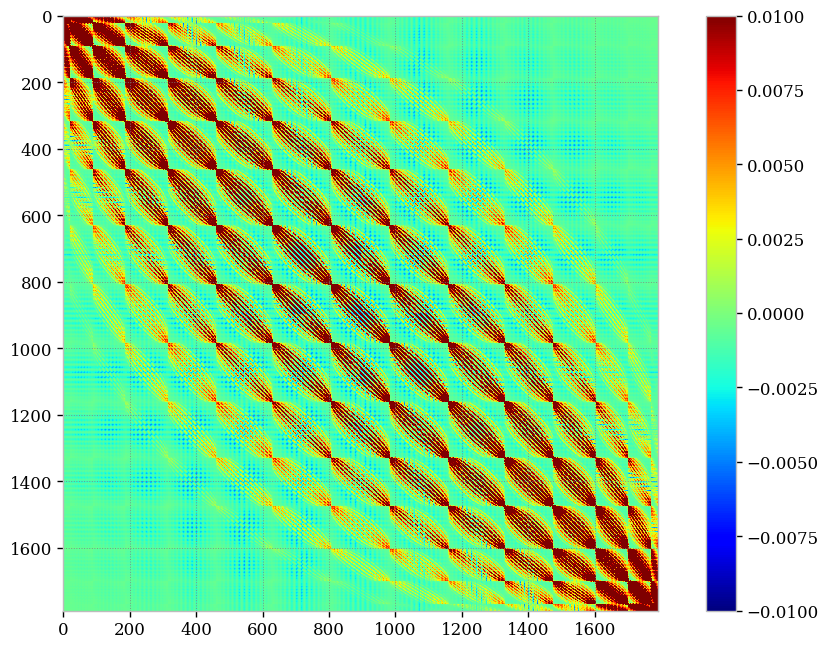

In [8]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter.likelihood,
    parameter_dict, 
    vmin = -0.01, vmax= 0.01
)

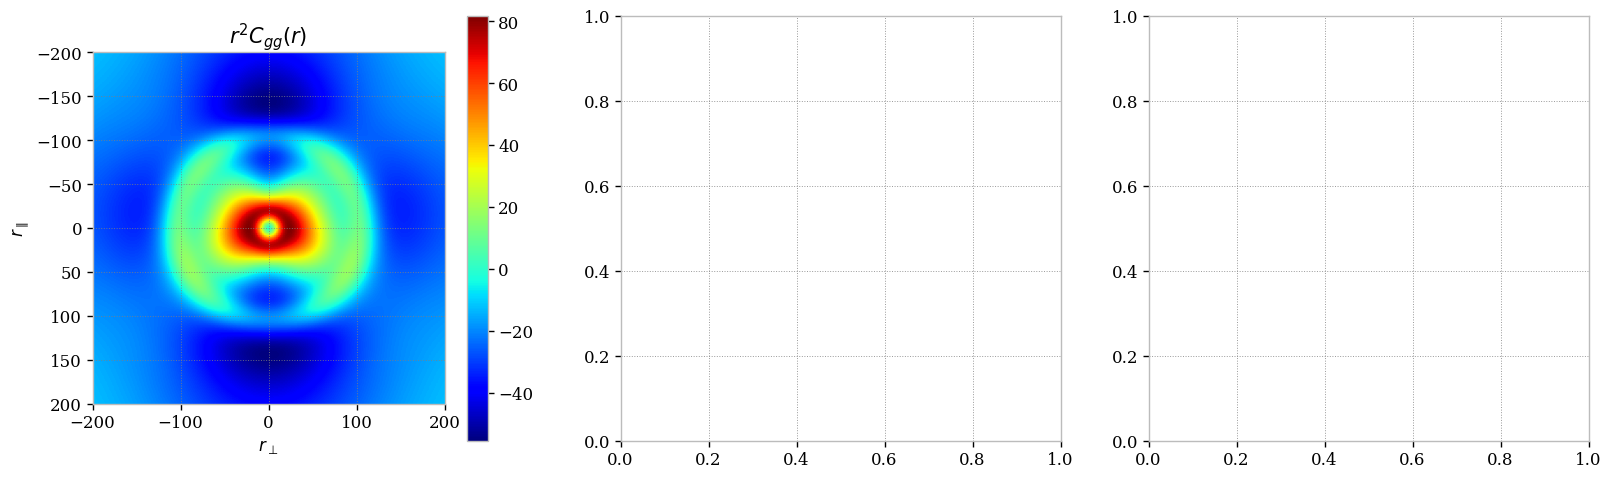

In [10]:
r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "ravouxcarreres",
    "density",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
    variant="nobeta"
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}


plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
